In [1]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import PreProcessor as pp
from keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention, Embedding, Dense, LayerNormalization, Dropout, Softmax, concatenate, Add
from keras import optimizers
import tensorflow as tf
from utils import *

In [2]:
dataset = pp.load_dataset("../adl-piano-midi")
ClassicSongs = pp.files_to_songs(dataset["Classical"])

channel_range, note_range, velocity_range, time_range = pp.ranges_from_songs(ClassicSongs,True,True,True,True)

n_Channels = int(channel_range[1])+1
n_Notes = int(note_range[1])+1
n_Velocities = int(velocity_range[1])+1

print("\nNumber of channels   :",n_Channels,"\nNumber of notes      :",n_Notes,"\nNumber of velocities :",n_Velocities,"\nTime range           :",time_range[0],time_range[1])


Number of channels   : 13 
Number of notes      : 120 
Number of velocities : 128 
Time range           : 0.0 190.285


In [3]:
seq_length = 30
val_split = 0.1
test_split = 0.1

Train_X, Train_y, Val_X, Val_y, Test_X, Test_y = pp.prep_data_transformer(seq_length,ClassicSongs,n_Channels,n_Notes,n_Velocities,val_split,test_split)

In [40]:
class MusicEmbedding(tf.keras.layers.Layer):
    def __init__(self, n_Channels, n_Notes, n_Velocities, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        
        tot_dim = int(n_Channels/2) + n_Notes + int(n_Velocities/5)
        self.d_Channels = int((d_model-1)*int(n_Channels/2)/tot_dim)
        self.d_Notes = int((d_model-1)*n_Notes/tot_dim)
        self.d_Velocities = int((d_model-1)*int(n_Velocities/5)/tot_dim)
        while self.d_Channels + self.d_Notes + self.d_Velocities != d_model - 1 : self.d_Notes += 1
            
        self.Channel_Embedding = Embedding(n_Channels, self.d_Channels)
        self.Notes_Embedding = Embedding(n_Notes, self.d_Notes)
        self.Velocities_Embedding = Embedding(n_Velocities, self.d_Velocities)
        self.seq = tf.keras.Sequential([
          Dense(dff, activation='relu'),
          Dense(d_model),
          Dropout(dropout_rate)
        ])

    def call(self, x):
        chan = self.Channel_Embedding(x[0])
        note = self.Notes_Embedding(x[1])
        velo = self.Velocities_Embedding(x[2])
        
        # Scale to values between 0 and 1 ? (/time_range[1])
        time = tf.expand_dims(x[3],-1)
        out = concatenate([chan,note,velo,time])
        return self.seq(out)

In [41]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, seq_length):
        super().__init__()
        self.d_model = d_model
        self.seq_length = seq_length
        self.pos_encoding = self.positional_encoding(seq_length, d_model)
        
    def positional_encoding(self, length, depth):
        depth = depth/2

        positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
        depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

        angle_rates = 1 / (10000**depths)         # (1, depth)
        angle_rads = positions * angle_rates      # (pos, depth)

        pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)],axis=-1) 

        return tf.cast(pos_encoding, dtype=tf.float32)[tf.newaxis, :, :]

    def call(self, x):
        # This factor sets the relative scale of the embedding and positonal_encoding.
        # x *= tf.math.sqrt(tf.cast(self.d_model, tf.float64))
        return x + self.pos_encoding

In [42]:
class SelfAttentionBlock(tf.keras.layers.Layer):
    # Dropout ??
    def __init__(self, num_heads, d_model, **kwargs):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads, d_model, **kwargs)
        self.layer_norm = LayerNormalization()
        self.add = Add()

    def call(self, x):
        attn_output = self.mha(query=x,value=x,key=x,use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layer_norm(x)
        return x

In [43]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          Dense(dff, activation='relu'),
          Dense(d_model),
          Dropout(dropout_rate)
        ])
        self.add = Add()
        self.layer_norm = LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [44]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,dff,dropout_rate=0.1):
        super().__init__()
        self.self_attention_block = SelfAttentionBlock(num_heads,d_model)
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention_block(x)
        x = self.ffn(x)
        return x

In [45]:
class Transformer(tf.keras.Model):
    def __init__(self, n_Channels, n_Notes, n_Velocities, max_time, seq_length, d_model, n_layers, n_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.embedding = MusicEmbedding(n_Channels, n_Notes, n_Velocities, d_model, dff, dropout_rate)
        self.pos_enc = PositionalEncoding(d_model, seq_length)
        self.layer_norm = LayerNormalization()
        self.dec_layers = [DecoderLayer(d_model, n_heads, dff, dropout_rate) for _ in range(n_layers)]
        self.out_chan = Dense(n_Channels, activation="softmax",name="Channels")
        self.out_note = Dense(n_Notes, activation="softmax",name="Notes")
        self.out_velo = Dense(1, activation = lambda x: (tf.sigmoid(x) * n_Notes),name="Velocities")
        self.out_time = Dense(1, activation = lambda x: ((1 + tf.tanh(x)) * 0.5 * max_time),name="Times")
    
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.pos_enc(x)
        x = self.layer_norm(x)
        for dec_layer in self.dec_layers:
            x = dec_layer(x)
        chan = self.out_chan(x)
        note = self.out_note(x)
        velo = self.out_velo(x)
        time = self.out_time(x)
        return [chan, note, velo, time]
    
    def generate(self, input_vec, output_length, mode="Max", T=1, reset=False):
        temp_vec = self.predict(input_vec)
        temp_vec = sample_probas(temp_vec,mode,T)
        output_vec = [[np.argmax(temp_vec[0][0,0,:])],[np.argmax(temp_vec[1][0,0,:])],[temp_vec[2][0,0,0]],[temp_vec[3][0,0,0]]]
        for _ in range(output_length-1):
            for i in range(4):
                input_vec[i] = np.concatenate((input_vec[i][:,1:],np.reshape([output_vec[i][-1]],(1,1))),axis=1)
            temp_vec = self.predict(input_vec)
            temp_vec = sample_probas(temp_vec,mode,T)
            output_vec[0] += [np.argmax(temp_vec[0][0,0,:])]
            output_vec[1] += [np.argmax(temp_vec[1][0,0,:])]
            output_vec[2] += [temp_vec[2][0,0,0]]
            output_vec[3] += [temp_vec[3][0,0,0]]
        for i in range(4):
            output_vec[i] = np.reshape(output_vec[i],(1,-1))
        return output_vec

In [46]:
d_model = 128
n_layers = 1
n_heads = 4
dff = 4*d_model

n_batch = 200
learning_rate = 0.01

optimizer= optimizers.Adam(learning_rate=learning_rate)

losses = {
    'output_1': 'categorical_crossentropy',    # Channels
    'output_2': 'categorical_crossentropy',    # Notes
    'output_3': 'mean_squared_error',          # Velocities
    'output_4': 'mean_squared_error'           # Times
}


loss_weights_start = {
    'output_1': 1.0,      # Channels
    'output_2': 1.0,      # Notes
    'output_3': 1.0,      # Velocities
    'output_4': 1.0       # Times
}

loss_weights_then  = {
    'output_1': 0.5,     # Channels
    'output_2': 5.0,     # Notes
    'output_3': 1e-3,    # Velocities
    'output_4': 1e-6     # Times
}

metrics = {
    'output_1': 'accuracy',          # Channels
    'output_2': 'accuracy',          # Notes
    'output_3': rounded_accuracy,    # Velocities
    'output_4': tol_accuracy         # Times
}

ClassicTransformer = Transformer(n_Channels, n_Notes, n_Velocities, time_range[1], seq_length, d_model, n_layers, n_heads, dff)
build = ClassicTransformer([Train_X[0][0:2,:],Train_X[1][0:2,:],Train_X[2][0:2,:],Train_X[3][0:2,:]])
ClassicTransformer.summary()
ClassicTransformer.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights_start, metrics=metrics)

loss = []
channels_accuracy = []
notes_accuracy = []
velocities_accuracy = []
times_accuracy = []

val_loss = []
val_channels_accuracy = []
val_notes_accuracy = []
val_velocities_accuracy = []
val_times_accuracy = []

Model: "transformer_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 music_embedding_4 (MusicEmb  multiple                 146585    
 edding)                                                         
                                                                 
 positional_encoding_4 (Posi  multiple                 0         
 tionalEncoding)                                                 
                                                                 
 layer_normalization_14 (Lay  multiple                 256       
 erNormalization)                                                
                                                                 
 decoder_layer_5 (DecoderLay  multiple                 396032    
 er)                                                             
                                                                 
 Channels (Dense)            multiple                

In [19]:
Chan, Note, Velo, Time = ClassicTransformer.generate([Train_X[0][0:1,:],Train_X[1][0:1,:],Train_X[2][0:1,:],Train_X[3][0:1,:]],30,"Original")

1/1 [==============================] - 0s 48ms/step


In [47]:
n_epochs_start = 0
n_epochs_then  = 5

if n_epochs_start > 0:
    history = ClassicTransformer.fit(Train_X,Train_y, epochs=n_epochs_start, batch_size=n_batch, validation_data=(Val_X,Val_y))

    loss += history.history['loss']
    channels_accuracy += history.history['output_1_accuracy']
    notes_accuracy += history.history['output_2_accuracy']
    velocities_accuracy += history.history['output_3_rounded_accuracy']
    times_accuracy += history.history['output_4_tol_accuracy']

    val_loss += history.history['val_loss']
    val_channels_accuracy += history.history['val_output_1_accuracy']
    val_notes_accuracy += history.history['val_output_2_accuracy']
    val_velocities_accuracy += history.history['val_output_3_rounded_accuracy']
    val_times_accuracy += history.history['val_output_4_tol_accuracy']

ClassicTransformer.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights_then, metrics=metrics)
history = ClassicTransformer.fit(Train_X,Train_y, epochs=n_epochs_then, batch_size=n_batch, validation_data=(Val_X,Val_y))

loss += history.history['loss']
channels_accuracy += history.history['output_1_accuracy']
notes_accuracy += history.history['output_2_accuracy']
velocities_accuracy += history.history['output_3_rounded_accuracy']
times_accuracy += history.history['output_4_tol_accuracy']

val_loss += history.history['val_loss']
val_channels_accuracy += history.history['val_output_1_accuracy']
val_notes_accuracy += history.history['val_output_2_accuracy']
val_velocities_accuracy += history.history['val_output_3_rounded_accuracy']
val_times_accuracy += history.history['val_output_4_tol_accuracy']

Epoch 1/5
284/284 [==============================] - 86s 296ms/step - loss: 22.5963 - output_1_loss: 0.8020 - output_2_loss: 3.9400 - output_3_loss: 2495.1799 - output_4_loss: 122.7644 - output_1_accuracy: 0.6890 - output_2_accuracy: 0.0380 - output_3_rounded_accuracy: 0.0760 - output_4_tol_accuracy: 0.2522 - val_loss: 20.3695 - val_output_1_loss: 0.7466 - val_output_2_loss: 3.7983 - val_output_3_loss: 1004.7354 - val_output_4_loss: 1.3843 - val_output_1_accuracy: 0.6972 - val_output_2_accuracy: 0.0519 - val_output_3_rounded_accuracy: 0.0048 - val_output_4_tol_accuracy: 0.0035
Epoch 2/5
284/284 [==============================] - 82s 289ms/step - loss: 20.0585 - output_1_loss: 0.7508 - output_2_loss: 3.7267 - output_3_loss: 1049.7104 - output_4_loss: 4.8488 - output_1_accuracy: 0.6953 - output_2_accuracy: 0.0561 - output_3_rounded_accuracy: 0.0043 - output_4_tol_accuracy: 0.0415 - val_loss: 19.6370 - val_output_1_loss: 0.7457 - val_output_2_loss: 3.6427 - val_output_3_loss: 1050.4629 - 

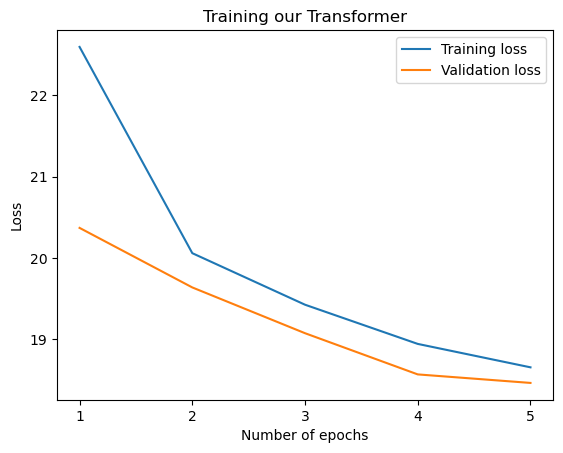

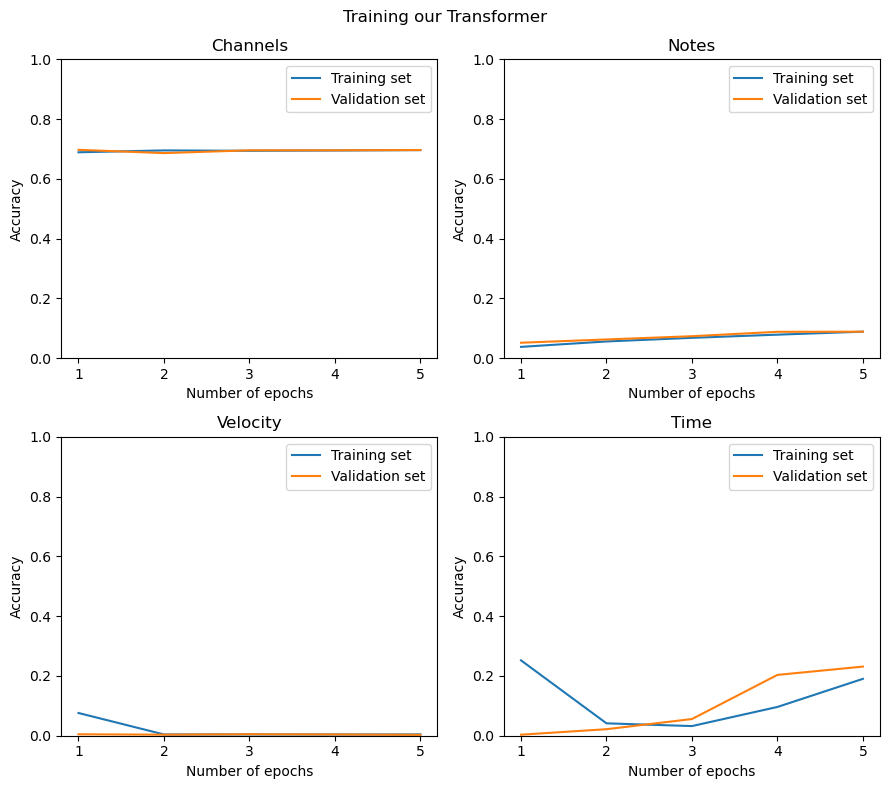

In [48]:
plot_training_results("Training our Transformer",loss,channels_accuracy,notes_accuracy,velocities_accuracy,times_accuracy,val_loss,val_channels_accuracy,val_notes_accuracy,val_velocities_accuracy,val_times_accuracy)

In [49]:
Out = ClassicTransformer.generate([Train_X[0][0:1,:],Train_X[1][0:1,:],Train_X[2][0:1,:],Train_X[3][0:1,:]],seq_length,"Original")

1/1 [==============================] - 0s 29ms/step


In [50]:
Out2 = ClassicTransformer.generate(Out,seq_length,"Original")

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'numpy.int32\'>"})', '(<class \'list\'> containing values of types {"<class \'numpy.float32\'>"})', '(<class \'list\'> containing values of types {"<class \'numpy.int64\'>"})'}), <class 'NoneType'>

In [60]:
ClassicTransformer.embedding.d_Velocities

21